In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

from keras.layers import Input, Dense
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython.display import display, clear_output

from PIL import Image, ImageSequence

In [5]:
!nvidia-smi -L # list GPUs available

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-1b733ae9-677b-c89f-b618-62b480a8af0b)


In [3]:
!export CUDA_VISIBLE_DEVICES=0

In [4]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [15]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [16]:
x_vals_all

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319,  0.5       ,
         0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092,  0.5       ,
         0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752,  0.5       ,
         0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [27]:
m1_list = np.unique(x_vals_all[:, -2])
m2_list = np.unique(x_vals_all[:, -1])

In [6]:
#model_all_BCE = tf.keras.models.load_model("model_all_BCE_3_4096")
model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

2023-11-08 15:35:15.002342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 15:35:19.523172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11759 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [7]:
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation="relu",
                         kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

4 Features 2 Parameter Semi Weakly Supervised Model

In [91]:
#only animtes for .05 sigfrac
#train weakly supervised model for a specific sigfrac
def train_wsmodel(sigfrac, m1, m2, w1, w2, epochs):

    sig_list = []
    w1_list = []
    w2_list = []
    w3_list = []

    max_SIC1 = []
    max_SIC2 = []

    fit_out = {}

    epsilon = 1e-6
    
    initial_learning_rate = 0.07

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
    )

    sig_space = np.logspace(-3, -1, 20)
    #for sigfrac in sig_space:
    sigfrac = sigfrac
    print("Signal Fraction: ", sigfrac)
    for l in model_all_MSE.layers:
        l.trainable=False

    model3 = createSimpleModel(w1)
    model32 = createSimpleModel(w2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_MSE(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1 + sigfrac * LLR - sigfrac
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = (LLR_xs / (1.+ LLR_xs))
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

    m1 = m1
    m2 = m2

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
    print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    with tf.device('/GPU:0'):
        for epoch in range(epochs):
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=1,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            w1_out = model_all2.trainable_weights[0].numpy()[0][0]
            w2_out = model_all2.trainable_weights[1].numpy()[0][0]
            fit_out[epoch] = [w1_out, w2_out]

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    return fit_out
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
#     max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#     max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

In [45]:
#fixed mass pair, varying sigfrac

z = {}
losses_list = []

epsilon = 1e-6

sig_space = np.logspace(-3, -1, 20)
for sig in sig_space:
    print("Signal Fraction: ", sig)
    #print(w1, w2)
    for w1 in m1_list:
        for w2 in m2_list:
            sigfrac = sig
    
            for l in model_all_MSE.layers:
                l.trainable=False

            model3 = createSimpleModel(w1)
            model32 = createSimpleModel(w2)

            inputs_hold3 = tf.keras.Input(shape=(1,))
            simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
            model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all_MSE(inputs2)
            LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
            LLR_xs = 1 + sigfrac*LLR - sigfrac
            #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
            ws = LLR_xs / (1.+ LLR_xs)
            model_all2 = Model(inputs = inputs, outputs = ws)
            model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            m1 = 1.5
            m2 = 4

            test_background = int(1/2 *len(x[0,0]))
            train_background = int(1/4 * len(x[0,0]))
            train_data = int(1/4 * len(x[0,0]))
            train_reference = int(1/4 * len(x[0,0]))
            #signal
            test_signal_length = int(1/2*len(x[m1,m2]))
            N = int(1/4 * (len(x[0,0])))
            signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

            x_vals_ = np.concatenate([x[0,0][test_background:],signal])
            #[reference (0), data_background (1), signal(1)]
            y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
            #print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

            #myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
            
            loss = model_all2.evaluate(x_vals_, y_vals_, verbose = 0)
            losses_list.append(loss)
    z[sigfrac, m1, m2] = losses_list
    #print(np.shape(losses_list))
    losses_list = []

Signal Fraction:  0.001
Signal Fraction:  0.0012742749857031334
Signal Fraction:  0.001623776739188721
Signal Fraction:  0.00206913808111479
Signal Fraction:  0.0026366508987303583
Signal Fraction:  0.003359818286283781
Signal Fraction:  0.004281332398719396
Signal Fraction:  0.00545559478116852
Signal Fraction:  0.0069519279617756054
Signal Fraction:  0.008858667904100823
Signal Fraction:  0.011288378916846888
Signal Fraction:  0.01438449888287663
Signal Fraction:  0.018329807108324356
Signal Fraction:  0.023357214690901212
Signal Fraction:  0.029763514416313176
Signal Fraction:  0.0379269019073225
Signal Fraction:  0.04832930238571752
Signal Fraction:  0.06158482110660261
Signal Fraction:  0.07847599703514611
Signal Fraction:  0.1


In [641]:
#np.save("z_sig33.5MSE", z)

In [533]:
# sig_space = np.logspace(-3, -1, 20)

# z_sig = {}
# loss_list = []

# count = 0
# for sig in sig_space:
#     if count > 1:
#         break
#     count+=1
#     for w1 in m1_list:
#         for w2 in m2_list:
#             loss_list.append(z_sig[sigfrac, w1, w2])
            
#     z_sig[sig, 3, 4.5] = loss_list
#     loss_list = []

In [50]:
sig_space

array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ])

In [775]:
z.keys()

dict_keys([(0.015, 3, 3)])

In [35]:
m1_values, m2_values = zip(*grid_axes.keys())

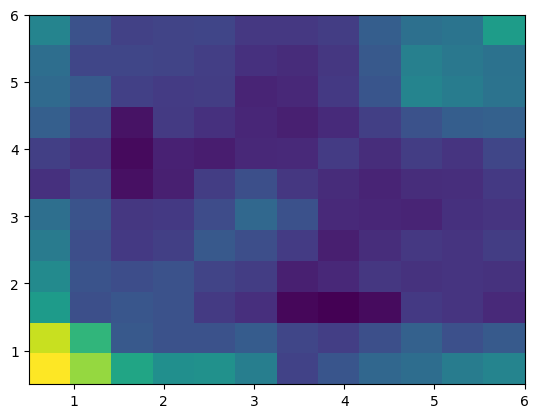

In [44]:
loss_values = list(z[sig_space[8], 1.5, 4])

plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=loss_values);

In [743]:
def loss_landscape_2D_notfit(m1, m2, w1_out, w2_out):
    m1_values, m2_values = zip(*z.keys())

    loss_values = list(z.values())
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    #fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
   # plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('2D Histogram of Losses (m1 = {}'.format(m1) + " | m2 = {})".format(m2))
    return h

loss_landscape_2D(3, 4.5, 6, 6);

In [606]:
z345 = np.load("z_sig34.5.npy", allow_pickle = True).item()

In [616]:
count = 0
test = {}
test_list = []
for m1 in m1_list:
    for m2 in m2_list:
        for w1 in m1_list:
            for w2 in m2_list:
                #print(w1, w2, m1, m2)
                count+=1
                test_list.append(count)
                
                if count == (len(m1_list) * len(m2_list)):
                    test[m1,m2] = test_list
                    count = 0
                    test_list = []

In [340]:
z_allm1m2 = np.load("z_allsigm1m2.npy", allow_pickle = True).item()
losses = []

epsilon = 1e-6
sigfrac = 0.05
print("Signal Fraction: ", sigfrac)
for m1 in m1_list:
    for m2 in m2_list:
        if (sigfrac,m1,m2) not in z_allm1m2:
            print(w1, w2, m1, m2)
        for w1 in m1_list:
            for w2 in m2_list:
                
                for l in model_all_MSE.layers:
                    l.trainable=False

                model3 = createSimpleModel(w1)
                model32 = createSimpleModel(w2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(4,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model_all_MSE(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1 + sigfrac*LLR - sigfrac
                #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
                ws = LLR_xs / (1.+ LLR_xs)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                if (sigfrac,m1,m2) in z_allm1m2:
                    break

                test_background = int(1/2 *len(x[0,0]))
                train_background = int(1/4 * len(x[0,0]))
                train_data = int(1/4 * len(x[0,0]))
                train_reference = int(1/4 * len(x[0,0]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2]))
                N = int(1/4 * (len(x[0,0])))
                signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_vals_ = np.concatenate([x[0,0][test_background:],signal])
                #[reference (0), data_background (1), signal(1)]
                y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
                
                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

                # for epoch in range(20):
                #     myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
                #     w1_out = model_all2.trainable_weights[0].numpy()[0][0]
                #     w2_out = model_all2.trainable_weights[1].numpy()[0][0]
                #     fit_out[epoch] = [w1_out, w2_out]
                
                with tf.device('/GPU:0'):
                    loss = model_all2.evaluate(x_vals_, y_vals_, verbose = 0)
                losses.append(loss)

        if (sigfrac,m1,m2) in z_allm1m2:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z_allm1m2[sigfrac,m1,m2] = losses
            losses = []
            np.save("z_allm1m2", z_allm1m2)

Signal Fraction:  0.05
Landscape for m1 = 0.5 and m2 = 0.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 1.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 1.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 2.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 2.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 3.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 3.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 4.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 4.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 5.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 5.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 6.0  already exists for 0.05 signal fraction
Landscape for m1 = 1.0 and m2 = 0.5  already exists f

In [403]:
z_allm1m2.keys()

dict_keys([(0.05, 0.5, 0.5), (0.05, 0.5, 1.0), (0.05, 0.5, 1.5), (0.05, 0.5, 2.0), (0.05, 0.5, 2.5), (0.05, 0.5, 3.0), (0.05, 0.5, 3.5), (0.05, 0.5, 4.0), (0.05, 0.5, 4.5), (0.05, 0.5, 5.0), (0.05, 0.5, 5.5), (0.05, 0.5, 6.0), (0.05, 1.0, 0.5), (0.05, 1.0, 1.0), (0.05, 1.0, 1.5), (0.05, 1.0, 2.0), (0.05, 1.0, 2.5), (0.05, 1.0, 3.0), (0.05, 1.0, 3.5), (0.05, 1.0, 4.0), (0.05, 1.0, 4.5), (0.05, 1.0, 5.0), (0.05, 1.0, 5.5), (0.05, 1.0, 6.0), (0.05, 1.5, 0.5), (0.05, 1.5, 1.0), (0.05, 1.5, 1.5), (0.05, 1.5, 2.0), (0.05, 1.5, 2.5), (0.05, 1.5, 3.0), (0.05, 1.5, 3.5), (0.05, 1.5, 4.0), (0.05, 1.5, 4.5), (0.05, 1.5, 5.0), (0.05, 1.5, 5.5), (0.05, 1.5, 6.0), (0.05, 2.0, 0.5), (0.05, 2.0, 1.0), (0.05, 2.0, 1.5), (0.05, 2.0, 2.0), (0.05, 2.0, 2.5), (0.05, 2.0, 3.0), (0.05, 2.0, 3.5), (0.05, 2.0, 4.0), (0.05, 2.0, 4.5), (0.05, 2.0, 5.0), (0.05, 2.0, 5.5), (0.05, 2.0, 6.0), (0.05, 2.5, 0.5), (0.05, 2.5, 1.0), (0.05, 2.5, 1.5), (0.05, 2.5, 2.0), (0.05, 2.5, 2.5), (0.05, 2.5, 3.0), (0.05, 2.5, 3.5),

In [29]:
import random
grid_axes = {}
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        grid_axes[m1,m2] = random.randint(1, 10)

In [790]:
z345 = np.load("z_sig34.5MSE.npy", allow_pickle = True).item()

In [806]:
z345.keys()

dict_keys([(0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.0379269019073225, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5)])

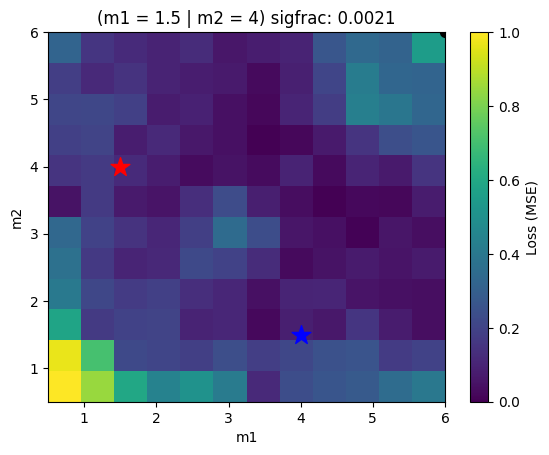

In [55]:
def loss_landscape_2D(sigfrac, m1, m2, w1_out, w2_out, z):
    m1_values, m2_values = zip(*grid_axes.keys())

    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (MSE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('(m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    return h

loss_landscape_2D(list(sig_space)[3], 1.5, 4, 6, 6, z);

Final weight coordinates: w1 = 2.9546401500701904  w2 = 4.470359802246094 


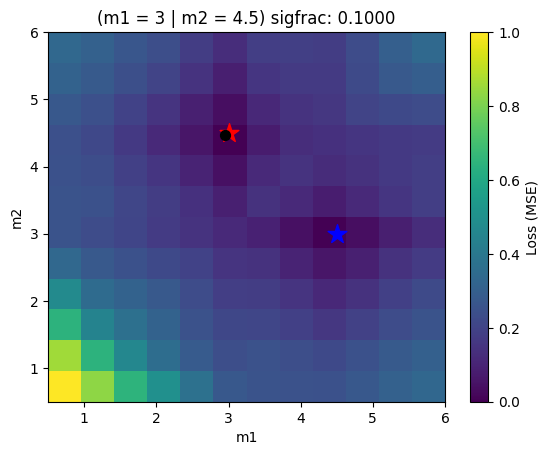

In [805]:
def animate(sigfrac, m1,m2, w1, w2, epochs, z):
    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        plt.figure()
        loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)
        plt.show()
        clear_output(wait=True)
        
    loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)
    print("Final weight coordinates: w1 = {} ".format(w1_fit_coord) + " w2 = {} ".format(w2_fit_coord))
        
sigfrac = sig_list[19]
w1, w2 = 2, 3
m1, m2 = 3, 4.5
epochs = 50
animate(sigfrac, m1, m2, w1, w2, epochs, z345)

Final weight coordinates: w1 = 0.997785210609436  w2 = 5.534912109375 


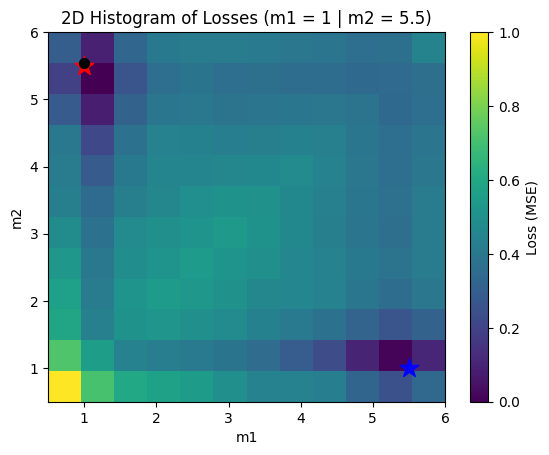

In [540]:
def animate_random(sigfrac, m1,m2, w1, w2, epochs):
    print(f"Initial Weights: {w1} {w2}")
    animate(sigfrac, m1, m2, w1, w2, epochs)
    
sigfrac = 0.05
random_number1 = random.uniform(0.1, 6.0)
random_number2 = random.uniform(0.1, 6.0)
m1, m2 = 1, 5.5
epochs = 50

animate_random(sigfrac, m1,m2, random_number1, random_number2, 50)

In [631]:
#save images to make them gifs
def create_gif(sigfrac, m1, m2, w1, w2, z):
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)

    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)

        image_path = os.path.join(output_directory, f'hist_{key}.png')
        plt.savefig(image_path)
        plt.close()

        clear_output(wait=True)

    #make the gif
    frames = []

    image_dir = '2dhist_images'
    image_files = os.listdir(image_dir)

    image_files = sorted([filename for filename in os.listdir(image_dir) if filename.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
    for filename in image_files:
        image = Image.open(os.path.join(image_dir, filename))
        frames.append(image)
        os.remove(image_dir+"/"+filename)

    output_gif_filename = f'{sigfrac, m1, m2, w1, w2}.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=200, loop=0)

In [58]:
sig_space = np.logspace(-3, -1, 20)
def create_gif(sigfrac, m1, m2, w1, w2, z):
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    frames = []  # List to store frames for all sigfrac values

    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

    loss_landscape_2D(sigfrac, m1, m2, 0, 0, z)

    image_path = os.path.join(output_directory, f'hist_{key}.png')
    plt.savefig(image_path)
    plt.close()
    clear_output(wait=True)

    # Append the image to the frames list
    frames.append(Image.open(image_path))

    return frames

# Loop through different sigfrac values and collect frames
all_frames = []
for sigfrac in sig_space:
    # w1 = random.uniform(0.1, 6.0)
    # w2 = random.uniform(0.1, 6.0)
    m1, m2 = 1.5, 4
    epochs = 35
    frames = create_gif(sigfrac, m1, m2, w1, w2, z)
    all_frames.extend(frames)

# Create the final GIF that combines all frames
output_gif_filename = 'combined14.5.gif'
all_frames[0].save(output_gif_filename, save_all=True, append_images=all_frames[1:], duration=400, loop=0)

Signal Fraction:  0.1
30232 90698 3023 0.09999338449325218
31/31 [==============================] - 0s 7ms/step - loss: 0.2431 - val_loss: 0.2433
1.5 4 4.08082 3.9322743
66/66 [==============================] - 0s 1ms/step


In [645]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

In [89]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

epsilon = 1e-6

#random_test_signal_length = random.randint(0, test_signal_length - 1)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
initial_learning_rate = 0.05 #placeholder till callback

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
)

num_data_points = len(X_train_) 
mse_loss = tf.keras.losses.MeanSquaredError()

def normalized_mse(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    num_data_points = tf.reduce_sum(1.0)
    normalized_mse = mse / num_data_points
    return normalized_mse

sig_space = np.logspace(-3, -1, 20)
count = 0
w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)
print(f"w1: {w1} w2: {w2}")
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_all_MSE.layers:
        l.trainable=False
    
    model3 = createSimpleModel(w1)
    model32 = createSimpleModel(w2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_MSE(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1 + sigfrac * LLR - sigfrac
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
    ws = (LLR_xs / (1.+ LLR_xs))
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=normalized_mse, optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

    m1 = 1.5
    m2 = 4

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)  
    count+=1

    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(512, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(512, activation='relu'))
#     model_cwola.add(Dense(512, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
#     max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#     max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

w1: 1.482 w2: 5.338
Signal Fraction:  0.001
Epoch 1/35
30/30 [==============================] - 1s 16ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/35
30/30 [==============================] - 0s 7ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 4/35
30/30 [==============================] - 0s 14ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 5/35
30/30 [==============================] - 0s 13ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss

KeyboardInterrupt: 

In [445]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

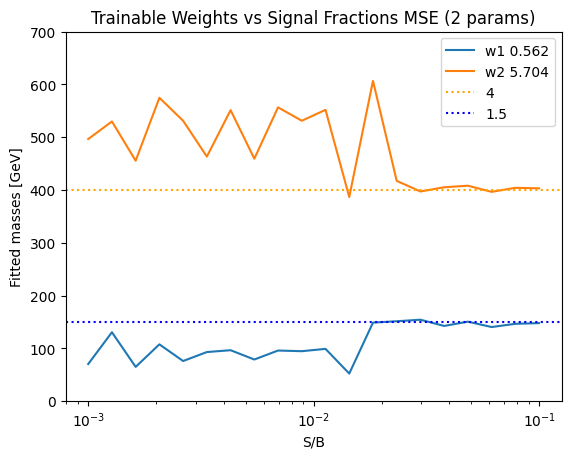

In [68]:
plt.plot(sig_list,np.array(w1_list)*100, label = f"w1 {w1}")
plt.plot(sig_list,np.array(w2_list)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

In [994]:
# plt.plot(sig_list,np.array(w3_list))
# plt.xscale("log")
# plt.yscale("log")
# plt.plot(sig_list,sig_list,ls=":",color="black")
# plt.xlabel("S/B")
# plt.ylabel("Fitted S/B")
# plt.title("S/B vs Fitted S/B")

Text(0, 0.5, 'max SIC')

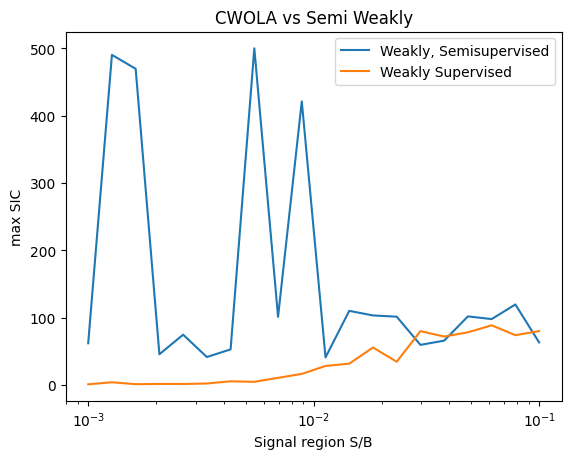

In [986]:
plt.plot(sig_list,max_SIC1,label="Weakly, Semisupervised")
plt.plot(sig_list,max_SIC2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

In [120]:
num_runs = 5
scores_list_runs = []
for _ in range(num_runs):
    sig_list = []
    w1_list = []
    w2_list = []
    #w3_list = []

    max_SIC1 = []
    max_SIC2 = []
    
    scores_list = []

    #accuracies = []

    initial_learning_rate = 0.05
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
    )

    epsilon = 1e-6
    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    print(f"w1: {w1} w2: {w2}")
    sig_space = np.logspace(-3, -1, 20)
    for sigfrac in sig_space:
        #sigfrac = 0.01
        print("Signal Fraction: ", sigfrac)
        for l in model_all_MSE.layers:
            l.trainable=False

        #print(w1, w2)

        model3 = createSimpleModel(w1)
        model32 = createSimpleModel(w2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all_MSE(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1 + sigfrac*LLR - sigfrac
        #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
        ws = LLR_xs / (1.+ LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

        m1 = 3
        m2 = 4.5

        test_background = int(1/2 *len(x[0,0]))
        train_background = int(1/4 * len(x[0,0]))
        train_data = int(1/4 * len(x[0,0]))
        train_reference = int(1/4 * len(x[0,0]))
        #signal
        test_signal_length = int(1/2*len(x[m1,m2]))
        N = int(1/4 * (len(x[0,0])))
        signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

        x_vals_ = np.concatenate([x[0,0][test_background:],signal])
        #[reference (0), data_background (1), signal(1)]
        y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
        print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])

        sig_list+=[sigfrac]
        w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
        w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
        #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

        print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

        scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
        y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        scores_list.append(scores)
    scores_list_runs.append(scores_list)

        #accuracy_model = pred_accuracy(y, list(scores))

        #accuracies.append(accuracy_model)

w1: 3.004 w2: 1.861
Signal Fraction:  0.001
30232 90698 30 0.0009923260121725325
Epoch 1/20
30/30 [==============================] - 1s 14ms/step - loss: 0.2499 - val_loss: 0.2499
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 7/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 9/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 10/20
30/30 [=================

In [169]:
np.shape(scores_list_runs)

(5, 20, 66327, 1)

In [141]:
#np.save("scores_list_runs.npy", scores_list_runs)

In [172]:
arrays = [scores_list_runs[0], scores_list_runs[1], scores_list_runs[2], scores_list_runs[3], scores_list_runs[4]]

In [173]:
scores_list_runs = arrays
arrays = np.array(scores_list_runs)
flattened_arrays = arrays.reshape((arrays.shape[0], arrays.shape[1], -1))
averaged_values = np.mean(flattened_arrays, axis=(0, 1))

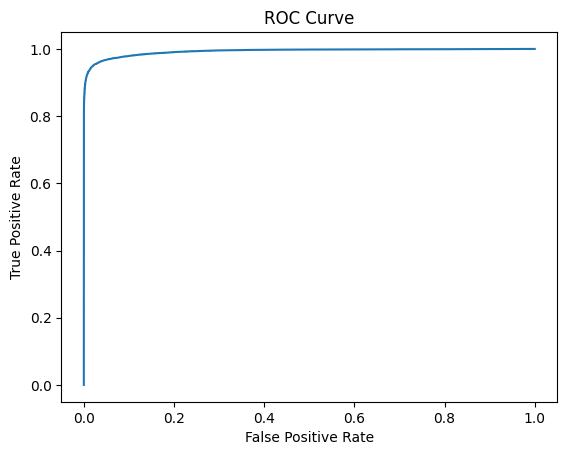

In [181]:
avg_scores = averaged_values
avg_fpr, avg_tpr, _ = metrics.roc_curve(y, avg_scores)
plt.plot(avg_fpr + epsilon, avg_tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

/tmp/ipykernel_1306402/186371360.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1306402/186371360.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


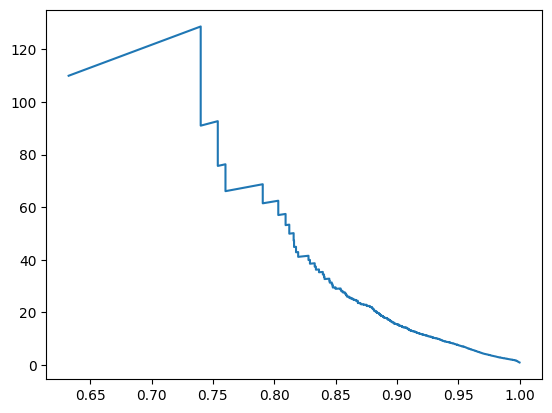

In [186]:
epsilon = 1e-6
plt.plot(tpr,tpr/np.sqrt(fpr))

In [112]:
def pred_accuracy(y_test, scores):
    background_count, signal_count = 0, 0

    predictions_list = []
    for pred in scores:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            signal_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            background_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

In [180]:
accuracy_model = pred_accuracy(y, list(avg_score))
accuracy_model

0.9636950261582764

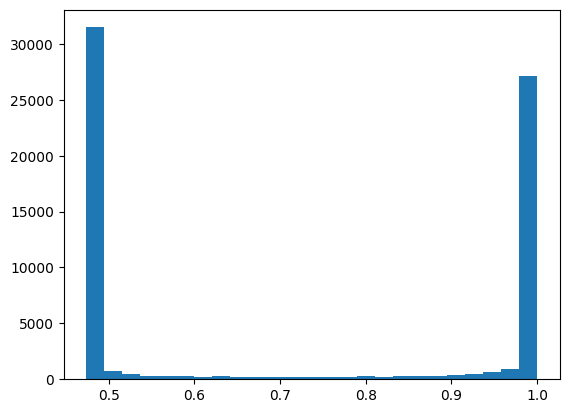

In [179]:
plt.hist(scores, bins = 25);

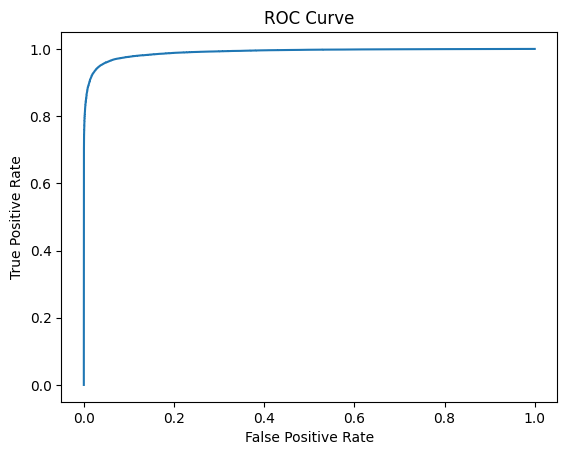

In [105]:
plt.plot(fpr + epsilon, tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

(0.0, 700.0)

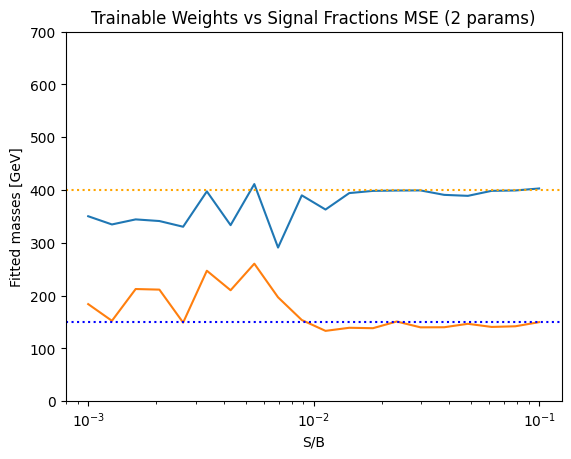

In [94]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

In [842]:
# plt.plot(sig_list,np.array(w3_list))
# plt.xscale("log")
# plt.yscale("log")
# plt.plot(sig_list,sig_list,ls=":",color="black")
# plt.xlabel("S/B")
# plt.ylabel("Fitted S/B")
# plt.title("S/B vs Fitted S/B")

In [826]:
w3_list

[0.022785036,
 0.025091713,
 0.022222342,
 0.02146514,
 0.024113385,
 0.02322863,
 0.021780586,
 0.026629865,
 0.025603738,
 0.026932005,
 0.022744117,
 0.025184644,
 0.030287577,
 0.027312301,
 0.03135526,
 0.032485493,
 0.033081815,
 0.035907187,
 0.032263987,
 0.041513465]

In [ ]:

m1 = 3
m2 = 4.5
w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)
epochs = 35
for sigfrac in sig_space:
    train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items()
    w1_fit_coord = value[0]
    w2_fit_coord = value[1]